In this notebook, we are trying to reproduce [the paper](https://pdfs.semanticscholar.org/edff/b62b32ffcc2b5cc846e26375cb300fac9ecc.pdf) for speaker change detection

**TODO**

- Use AMI Corpus with feature extraction with pyannote.

## Review

**Sequence Labelling** 

They think this task as a binary classification. Thus, they label changing frame as a **1** and non-changing frame as a **0**. So that, they use the _binary cross-entropy loss function_.

**Network Architecture**
- 2 Bi-LSTM
    - 64 and 32 outputs respectively.
- Multi Layer Perceptron
    - 3 Fully Connected Feedforward Layers
        - 40, 20, 1 dimensional respectively.
    - Tanh activation for first 2 layer
    - Sigmoid activation for last layer
    
**Feature Extraction**
- "35-dimensional acoustic features are extracted every 16ms on a 32ms window using [Yaafe toolkit](http://yaafe.sourceforge.net)."
    - 11 Mel-Frequency Cepstral Coefficients (MFCC), 
    - Their first and second derivatives,
    - First and second derivatives of the energy.

**Class Imbalance**

- _"The number of positive labels isincreased artificially by labeling as positive every frame in the direct neighborhood of the manually annotated change point."_
- A positive neighborhood of 100ms (50ms on both sides) is used around each change point, to partially solve the class imbalance problem.

**Subsequences**

- _"The long audio sequences are split into short fixed-length overlapping sequences."_

**Prediction**

- _"Finally, local score maxima exceeding a pre-determined threshold θ are marked as speaker change points."_

**Training**

- Subsequences for training are 3.2s long with a step of 800ms (i.e. two adjacent sequences overlap by 75%).

## Code

### Feature Extraction

We will use Yaafe Toolkit. (To see all available features, you can use _!yaafe -l_) To learn how we can do that, start with http://yaafe.github.io/Yaafe/manual/quickstart.html#quick-start-using-yaafe


In [ ]:
# You can view a description of each feature (or output format) with the -d option:

!yaafe -d MFCC

In [ ]:
!yaafe -d Energy

Let's determine blockSize and stepSize. 

If we have 16kHz audio signal(in AMI, we have 16kHz), for 32 ms block, we need 16x32, For the stepsize as 16 ms, we need 16x16 size.

We need these features:

- mfcc: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11
- mfcc_d1: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 > Derivate DOrder=1
- mfcc_d2: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 > Derivate DOrder=2
- energy_d1: Energy blockSize=512 stepSize=256  > Derivate DOrder=1
- energy_d2: Energy blockSize=512 stepSize=256  > Derivate DOrder=2

To extract all of these, we will use [this technique](http://yaafe.github.io/Yaafe/manual/quickstart.html#extract-several-features). Shortly, we will write all these features into single text file.

In [ ]:
f = open("featureplan.txt", "w")
f.write("mfcc: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 \n"
        "mfcc_d1: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 > Derivate DOrder=1 \n"
        "mfcc_d2: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 > Derivate DOrder=2 \n"
        "energy_d1: Energy blockSize=512 stepSize=256  > Derivate DOrder=1 \n"
        "energy_d2: Energy blockSize=512 stepSize=256  > Derivate DOrder=2")
f.close() 

In [ ]:
cat featureplan.txt

In [ ]:
#!ls

In [ ]:
!yaafe -c featureplan.txt -r 16000 a2002011001-e02-16kHz.wav -p Precision=8 -p Metadata=False

In [ ]:
filename = "ES2009a"
matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".Mix-Headset.npy")
print (matrix_of_single_audio.shape)

In [1]:
import math
import numpy as np
import glob
import os
import matplotlib.pyplot as pp

%matplotlib inline


def create_data_for_supervised(root_dir, hop, win_len, from_ep=0, to_ep=0, boost_for_imbalance=False, how_much_boost=6):
    all_audio_paths = glob.glob(os.path.join(root_dir, '*wav'))
    matrix_of_all_audio = []
    
    output_all_array = []
    num = 0
    
    for single_audio_path in all_audio_paths:
        num += 1
        
        if ((num >= from_ep) and (num < to_ep)):
            
            end_time_array_second = []

            filename = (single_audio_path.split("/")[-1]).split(".")[0]
            
            try:
                matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".Mix-Headset.npy")
                array_of_single_audio = np.ravel(matrix_of_single_audio)

                if (matrix_of_single_audio is not None):

                    matrix_of_all_audio.extend(array_of_single_audio)
                    print (single_audio_path + " is done.")

                    main_set = "./txt_files/" + filename + "_end_time.txt"# FILENAME PATH for TXT

                    with open(main_set) as f:
                        content = f.readlines()

                    # you may also want to remove whitespace characters like `\n` at the end of each line


                    # need to open text file
                    # after that, point the end point of speaker
                    # add 1 to point of speaker, add 0 otherwise
                    # time is in second format at the txt file
                    content = [x.strip() for x in content] 

                    for single_line in content:

                        end_time_array_second.append(single_line)

                        # we use following method to get milisecond version
                        # float(win_len + ((offset+100) * hop)) 
                        # we need to inversion of that
                    # print (end_time_array_second)

                    output_array = np.zeros(matrix_of_single_audio.shape[0])

                    for end_time in end_time_array_second:
                        end_time_ms = float(end_time)*1000
                        which_start_hop = (end_time_ms-win_len)/hop # now we know, milisecond version of change
                                                    # which is located after which_hop paramater
                                                    # add 2 and round to up
                        which_end_hop = end_time_ms/hop # round to up

                        start_location = math.ceil(which_start_hop + 1)
                        end_location = math.ceil(which_end_hop)

                        # print ("s:", start_location)
                        # print ("e:", end_location)
                        if (boost_for_imbalance==False):
                            output_array[start_location:end_location+1] = 1.0

                        else:
                            output_array[start_location-how_much_boost:end_location+1+how_much_boost] = 1.0
                    output_all_array.extend(output_array)
            except:
                print ("Pass this file...")
                pass
            # print (output_array)
            # print (output_array.mean())
            # ar = np.arange(matrix_of_single_audio.shape[1]) # just as an example array
            # pp.plot(ar, output_array, 'x')
            # pp.show()
                
            
    audio_array = np.asarray(matrix_of_all_audio)
    audio_array = np.reshape(matrix_of_all_audio, (-1, 59))
    
    input_array = audio_array
    
    
    print("inputs shape: ", input_array.shape)
    
    output_all_array = np.asarray(output_all_array)
    output_all_array = np.expand_dims(output_all_array, axis=1)
    print("outputs shape: ", output_all_array.shape)

    return (input_array, output_all_array)

In [4]:
from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.models import Model
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects


frame_shape = (800, 59)

## Network Architecture

input_frame = keras.Input(frame_shape, name='main_input')

bidirectional_1 = layers.Bidirectional(layers.LSTM(96, return_sequences=True))(input_frame)
bidirectional_2 = layers.Bidirectional(layers.LSTM(60, activation='tanh', return_sequences=True))(bidirectional_1)

tdistributed_1 = layers.TimeDistributed(layers.Dense(80, activation='tanh'))(bidirectional_2)
tdistributed_2 = layers.TimeDistributed(layers.Dense(40, activation='tanh'))(tdistributed_1)
tdistributed_3 = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(tdistributed_2)
tdistributed_3 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(tdistributed_3)


# WE DO NOT NEED IT FOR TRAINING. SO DISCARD.
## Source: https://stackoverflow.com/questions/37743574/hard-limiting-threshold-activation-function-in-tensorflow
def step_activation(x):
    threshold = 0.4
    cond = tf.less(x, tf.fill(value=threshold, dims=tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

# https://stackoverflow.com/questions/47034692/keras-set-output-of-intermediate-layer-to-0-or-1-based-on-threshold

step_activation = layers.Dense(1, activation=step_activation, name='threshold_activation')(tdistributed_3)



model = Model(input_frame, tdistributed_3)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.0001, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer="rmsprop")

In [ ]:
## WITH ATTENTION!!!!!


from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.models import Model
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects


frame_shape = (800, 59)

## Network Architecture

input_frame = keras.Input(frame_shape, name='main_input')

bidirectional_1 = layers.Bidirectional(layers.LSTM(96, return_sequences=True))(input_frame)
bidirectional_2 = layers.Bidirectional(layers.LSTM(60, activation='tanh', return_sequences=True))(bidirectional_1)

# compute importance for each step
attention = layers.Dense(1, activation='tanh')(bidirectional_1)
attention = layers.Flatten()(attention)
attention = layers.Activation('softmax')(attention)
attention = layers.RepeatVector(120)(attention)
attention = layers.Permute([2, 1])(attention)

multiplied = layers.Multiply()([bidirectional_2, attention])
sent_representation = layers.Dense(512)(multiplied)

tdistributed_1 = layers.TimeDistributed(layers.Dense(80, activation='tanh'))(sent_representation)
tdistributed_2 = layers.TimeDistributed(layers.Dense(40, activation='tanh'))(tdistributed_1)
tdistributed_3 = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(tdistributed_2)
tdistributed_3 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(tdistributed_3)


# WE DO NOT NEED IT FOR TRAINING. SO DISCARD.
## Source: https://stackoverflow.com/questions/37743574/hard-limiting-threshold-activation-function-in-tensorflow
def step_activation(x):
    threshold = 0.4
    cond = tf.less(x, tf.fill(value=threshold, dims=tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

# https://stackoverflow.com/questions/47034692/keras-set-output-of-intermediate-layer-to-0-or-1-based-on-threshold

step_activation = layers.Dense(1, activation=step_activation, name='threshold_activation')(tdistributed_3)



model = Model(input_frame, tdistributed_3)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.0001, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer="rmsprop")

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 800, 59)      0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 800, 192)     119808      main_input[0][0]                 
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 800, 1)       193         bidirectional_5[0][0]            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 800)          0           dense_3[0][0]                    
__________________________________________________________________________________________________
activation

In [ ]:
# input_array, output_array = create_data_for_supervised ("./amicorpus/*/audio/", 16, 32, 0, 3, True)

In [ ]:
# print(input_array.shape)
# print (output_array.shape)

In [6]:
from keras.models import load_model

how_many_step = 12
ix_step = 0
from_epi = 0

while (ix_step < how_many_step):
    ix_step += 1
    
    print ("STEP:", ix_step)
    
    input_array, output_array = create_data_for_supervised ("./amicorpus/*/audio/", 10, 25, from_epi, from_epi+5, True, 5)
    
    max_len = 800 # how many frame will be taken
    step = 800 # step size.

    input_array_specified = []
    output_array_specified = []

    for i in range (0, input_array.shape[0]-max_len, step):
        single_input_specified = (input_array[i:i+max_len,:])
        single_output_specified = (output_array[i:i+max_len,:])
        
        input_array_specified.append(single_input_specified)
        output_array_specified.append(single_output_specified)

    output_array_specified = np.asarray(output_array_specified)
    input_array_specified = np.asarray(input_array_specified)
    
    try:
    
        model.fit(input_array_specified, output_array_specified,
               epochs=2,
               batch_size=16,
               shuffle=True)
        
    except:
        print ("Pass this epoch.")
        pass
    
    # https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

    model.save_weights('bilstm_weights.h5')    
    
    input_array = []
    output_array = []
    
    from_epi += 6

STEP: 1
./amicorpus/IN1002/audio/IN1002.Mix-Headset.wav is done.
./amicorpus/IS1000d/audio/IS1000d.Mix-Headset.wav is done.
./amicorpus/IS1007c/audio/IS1007c.Mix-Headset.wav is done.
./amicorpus/ES2016a/audio/ES2016a.Mix-Headset.wav is done.
inputs shape:  (858822, 59)
outputs shape:  (858822, 1)
Epoch 1/2
  48/1073 [>.............................] - ETA: 7:25 - loss: 0.5665Pass this epoch.
STEP: 2
./amicorpus/TS3005c/audio/TS3005c.Mix-Headset.wav is done.
./amicorpus/IS1003c/audio/IS1003c.Mix-Headset.wav is done.
./amicorpus/EN2009c/audio/EN2009c.Mix-Headset.wav is done.
./amicorpus/ES2004c/audio/ES2004c.Mix-Headset.wav is done.
./amicorpus/IS1005a/audio/IS1005a.Mix-Headset.wav is done.


KeyboardInterrupt: 

In [6]:
input_array_specified.shape

(1089, 800, 59)

In [7]:
output_array_specified.shape

(1089, 800, 1)

In [ ]:
# model.load_weights("bilstm_weights.h5")

In [8]:
# To get prediction, we need to give k, 800, 59 array to system.
# Our output is like k, 320, 1
# We need to convert it into milisecond version

def create_prediction(filename, hop, win_len, threshold, lstm_system):
    
    prediction_array = []
    matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".Mix-Headset.npy")

    ix_frame = 0
    
    while (ix_frame+800<matrix_of_single_audio.shape[0]):        
        # print (matrix_of_single_audio.shape)
        # print (np.expand_dims(matrix_of_single_audio[ix_frame:ix_frame+800], axis=0).shape)
        prediction = model.predict(np.expand_dims(matrix_of_single_audio[ix_frame:ix_frame+800], axis=0))
        prediction = prediction.squeeze(axis=2)
        prediction = prediction.squeeze(axis=0)

        prediction_array.append(prediction)
        # print (prediction.shape)
        ix_frame += 800
        
    prediction_array = np.asarray(prediction_array)
    print (prediction_array.shape)
    
    prediction_array_rav = np.ravel(prediction_array)

    
    prediction_array_sec = []
    ix_frame_pred = 0

    for pred in prediction_array_rav:
        if (pred > threshold):
            ms_version = float(win_len + (ix_frame_pred * hop)) # milisecond version to represent end point of first embed            
            prediction_array_sec.append(ms_version/1000)
            
        ix_frame_pred += 1
            

    prediction_array_smooth = []
    for pred in prediction_array_sec:
        if ((pred-(hop*0.001)) not in (prediction_array_sec)):
            prediction_array_smooth.append(pred)
            
    np.savetxt(fname=filename + "_prediction.txt", X=prediction_array_smooth, 
               delimiter=' ', fmt='%1.3f')

    return (prediction_array, prediction_array_rav)

In [9]:
thres = 0.2

In [10]:
(kk, kk_r) = create_prediction("TS3003b", 10, 25, threshold = thres, lstm_system=model)

(276, 800)


In [11]:
kk.shape

(276, 800)

In [12]:
kk.mean()

0.021644002

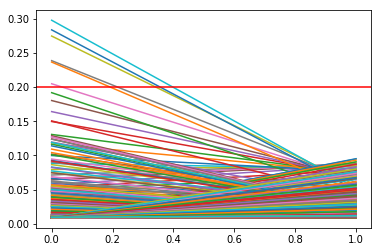

In [13]:
import matplotlib.pyplot as pp
%matplotlib inline

pp.plot(kk[130:132])
pp.axhline(y=thres, color='r', linestyle='-')
pp.show()

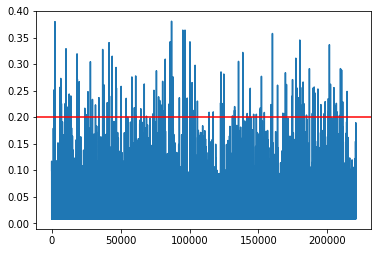

In [14]:
import matplotlib.pyplot as pp
%matplotlib inline

pp.plot(kk_r)
pp.axhline(y=thres, color='r', linestyle='-')
pp.show()

In [ ]:
from pyannote.database import get_protocol
protocol = get_protocol('AMI.SpeakerDiarization.MixHeadset')

In [ ]:
for i in protocol.test():
    if (i["uri"] == 'TS3003b.Mix-Headset'):
         reference = i['annotation']

In [ ]:
reference

We need to balance our dataset to get better result. For that, we will crop the segment which include 1 speaker and its duration is long.

## With Librosa

In [ ]:
import librosa
import os
import glob
import numpy as np
import sys

def wav_to_matrix(filename, hop, win_len): # hop and win_len in milisecond 
    audio, sr = librosa.load(filename)
    # https://github.com/librosa/librosa/issues/584
    mfccs = librosa.feature.mfcc(audio, sr, n_mfcc=11, hop_length=int(float(hop/1000)*sr), n_fft=int(float(win_len/1000)*sr))
    mfccs_d1 = librosa.feature.delta(mfccs)
    mfccs_d2 = librosa.feature.delta(mfccs, order=2)
    energy = librosa.feature.rmse(y=audio, hop_length=int(float(hop/1000)*sr), frame_length=int(float(win_len/1000)*sr))
    energy_d1 = librosa.feature.delta(energy)
    energy_d2 = librosa.feature.delta(energy, order=2)
    print (mfccs.shape)
    print (mfccs_d1.shape)
    print (mfccs_d2.shape)
    print (energy_d1.shape)
    print (energy_d2.shape)

    a = np.vstack((mfccs, mfccs_d1, mfccs_d2, energy_d1, energy_d2))
    # line_mfccs = np.ravel(mfccs, order='F')
    return a

In [ ]:
import math
import matplotlib.pyplot as pp

%matplotlib inline


def create_data_for_supervised(root_dir, hop, win_len, from_ep = 0, to_ep=0, boost_for_imbalance=False):
    all_audio_paths = glob.glob(os.path.join(root_dir, '*wav'))
    matrix_of_all_audio = []
    
    output_all_array = []
    
    num = 0
    
    for single_audio_path in all_audio_paths:
        num += 1
        
        if ((num >= from_ep) and (num < to_ep)):
            
            end_time_array_second = []
            try:
                filename = (single_audio_path.split("/")[-1]).split(".")[0]
                matrix_of_single_audio = wav_to_matrix(single_audio_path, hop, win_len)
                array_of_single_audio = np.ravel(matrix_of_single_audio)

                if (matrix_of_single_audio is not None):

                    print (matrix_of_single_audio.shape)
                    matrix_of_all_audio.extend(array_of_single_audio)
                    print (single_audio_path + " is done.")

                    main_set = "./txt_files/" + filename + "_end_time.txt"# FILENAME PATH for TXT

                    with open(main_set) as f:
                        content = f.readlines()

                    # you may also want to remove whitespace characters like `\n` at the end of each line


                    # need to open text file
                    # after that, point the end point of speaker
                    # add 1 to point of speaker, add 0 otherwise
                    # time is in second format at the txt file
                    content = [x.strip() for x in content] 

                    for single_line in content:

                        end_time_array_second.append(single_line)

                        # we use following method to get milisecond version
                        # float(win_len + ((offset+100) * hop)) 
                        # we need to inversion of that
                    output_array = np.zeros(matrix_of_single_audio.shape[1])

                    for end_time in end_time_array_second:
                        end_time_ms = float(end_time)*1000
                        which_start_hop = (end_time_ms-win_len)/hop # now we know, milisecond version of change
                                                    # which is located after which_hop paramater
                                                    # add 2 and round to up
                        which_end_hop = end_time_ms/hop # round to up

                        start_location = math.ceil(which_start_hop + 1)
                        end_location = math.ceil(which_end_hop)

                        # print ("s:", start_location)
                        # print ("e:", end_location)
                        if (boost_for_imbalance==False):
                            output_array[start_location:end_location+1] = 1.0

                        else:
                            output_array[start_location-12:end_location+13] = 1.0
                    output_all_array.extend(output_array)
            except:
                print ("Pass this file..")
                pass
            # print (output_array)
            print (output_array.mean())
            # ar = np.arange(matrix_of_single_audio.shape[1]) # just as an example array
            # pp.plot(ar, output_array, 'x')
            # pp.show()
                

    audio_array = np.asarray(matrix_of_all_audio)
    audio_array = np.reshape(matrix_of_all_audio, (35,-1))
   
        
    input_array = np.asarray(audio_array)
    input_array = input_array.reshape((len(input_array), np.prod(input_array.shape[1:])))  
    print(input_array.shape)
    
    output_all_array = np.asarray(output_all_array)
    output_all_array = np.expand_dims(output_all_array, axis=0)
    print(output_array.shape)

    return (input_array, output_all_array)

In [ ]:
inn, out = create_data_for_supervised ("./amicorpus/*/audio/", 16, 32, 0, 2, True)

In [ ]:
k = wav_to_matrix("How to Read a Research Paper.mp3", 32, 32)

In [ ]:
import matplotlib.pyplot as pp
%matplotlib inline

pp.plot(np.swapaxes(k, 0, 1))
pp.axhline(y=0.5, color='r', linestyle='-')
pp.show()

### Create Subsequences with Label

At that point, we should create training and test data with their label. Also, we can use directly [pyannote.metrics](https://github.com/pyannote/pyannote-metrics)

### Deep Learning Architecture

We can directly upload the model's architecture from the .yml file which is provided by writer.

However, I want to directly write all steps.

In [ ]:
# Author's .yml files

!wget https://raw.githubusercontent.com/yinruiqing/change_detection/master/model/architecture.yml

In [ ]:
# Load to model

from keras.models import model_from_yaml
yaml_file = open('architecture.yml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)

In [ ]:
rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer="rmsprop")

In [ ]:
import keras
print (keras.__version__)

In [ ]:
model.summary()

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.layers.advanced_activations import *
from keras.utils.generic_utils import get_custom_objects


frame_shape = (320, 35)

## Network Architecture

input_frame = keras.Input(frame_shape, name='main_input')

bidirectional_1 = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(input_frame)
bidirectional_2 = layers.Bidirectional(layers.LSTM(20, activation='tanh', return_sequences=True))(bidirectional_1)

tdistributed_1 = layers.TimeDistributed(layers.Dense(40, activation='tanh'))(bidirectional_2)
tdistributed_2 = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(tdistributed_1)
tdistributed_3 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(tdistributed_2)


# WE DO NOT NEED IT FOR TRAINING. SO DISCARD.
## Source: https://stackoverflow.com/questions/37743574/hard-limiting-threshold-activation-function-in-tensorflow
def step_activation(x):
    threshold = 0.4
    cond = tf.less(x, tf.fill(value=threshold, dims=tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

# https://stackoverflow.com/questions/47034692/keras-set-output-of-intermediate-layer-to-0-or-1-based-on-threshold

step_activation = layers.Dense(1, activation=step_activation, name='threshold_activation')(tdistributed_3)



model = Model(input_frame, tdistributed_3)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer="rmsprop")

In [ ]:
model.summary()

In [ ]:
# To save our model

model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [ ]:
# To look our model

!cat model.yaml

In [ ]:
from keras.models import load_model

how_many_step = 15
ix_step = 0
from_epi = 0

while (ix_step < how_many_step):
    ix_step += 1
    
    input_array, output_array = create_data_for_supervised ("./amicorpus/*/audio/", 16, 32, from_epi, from_epi+5, True)
    
    max_len = 320 # how many frame will be taken
    step = 240 # step size.

    input_array_specified = []
    output_array_specified = []

    for i in range (0, input_array.shape[1]-max_len, step):
        single_input_specified = np.transpose(input_array[:,i:i+max_len])
        single_output_specified = np.transpose(output_array[:,i:i+max_len])
        
        input_array_specified.append(single_input_specified)
        output_array_specified.append(single_output_specified)

    output_array_specified = np.asarray(output_array_specified)
    input_array_specified = np.asarray(input_array_specified)
    
    model.fit(input_array_specified, output_array_specified,
               epochs=5,
               batch_size=32,
               shuffle=True)
    
    # https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

    model.save_weights('bilstm_weights.h5')    
    
    input_array = []
    output_array = []
    
    from_epi += 4

In [ ]:
input_array_specified.shape

In [ ]:
single_input_specified.shape

In [ ]:
output_array_specified.shape

In [ ]:
single_output_specified.shape

In [ ]:
output_array.shape

In [ ]:
input_array.shape

In [ ]:
input_array[:,i:i+max_len].shape

In [ ]:
output_array[:,i:i+max_len].shape

In [ ]:
output_array[:,20].shape